In [132]:
%matplotlib inline

from __future__ import division, print_function

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.special import gamma
import time
from scipy import integrate

#Typical plot parameters that make for pretty plots
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['font.size'] = 20.0
mpl.rc('text', usetex='true') 

### Set my random seed

In [5]:
np.random.seed(int((time.time()%1)*1.0e8))

### Proof that metropolis algorithm works

---

Boltzmann factor is $e^{-E/kT}$ for energy E.

Suppose n$_r$ is the number of systems in state r and n$_s$ is the number of systems in state s.  Assume the system is ergodic (any state can be reached from any other state in one or more steps [think particles in a box]) and E$_r$ > E$_s$ where r and s differ by one particle's one move within a square of side 2*alpha.  Recall, alpha is the MC step size.

Let P_rs be the probability of moving from r to s.  P$_{rs}$ = $P_{sr}$.  The total number of systems moving from r to s is n$_r$ * P$_rs$ (n_r is number of states in r, not a number density) since all moves to a lower energy state (downhill) are accepted.  In the other direction, we must consider the Boltzmann factor.

The number of systems moving from s to r (uphill) is n$_s$ * P$_sr$ * $e^{-(E_r - E_s)/kT}$.

In equilibrium, the rate of going one way equals the rate of going the other way.  From this, we get:

n$_r$ * P$_rs$ = n$_s$ * P$_sr$ * $e^{-(E_r - E_s)/kT}$ where since P$_{rs}$ = $P_{sr}$, we get

$$
\frac{n_r}{n_s} = e^{-(E_r - E_s)/kT}
$$

giving us the Boltzmann distribution for a classical system.

### Metropolis algorithm notes

---

For step size alpha:

If alpha is too large, most moves will be rejected.  If alpha is too small, the configuration will not change enough and you will not sample enough of states.  Choose your step step so your acceptance ratio is somewhere between 0.3 and 0.7 (0.44 is a good one for some reason).

# Ising model for magnetism

link: https://en.wikipedia.org/wiki/Ising_model

Imagine that you have a 2D lattice where at each point, the spin can be up or down.  There is some temperature T$_c$ where for temperatures about that, the magnetism goes away.

The Hamiltonian is
$$
H = -\sum_{i,j \ neighbors} s_i s_j
$$

assuming periodic boundary conditions where each s can be +1 or -1.  In the ground state at time = 0, all states are pointing up or down to give lowest energy.

To solve, go to random state, flip it, compute change in energy via Metropolis algorithm.

Note that for an NxN lattice, there are $2^{n^2}$ possible states!

### Algorithm to find the ground state:

---

```
Note: pseudo-core is a c/c++ and python hybrid by the looks of it

1) Initialize spins, energy, and magnetization

    E = 0.0 # Init energy
    M = 0.0 # Init magnetization
    total_M = 0.0 # keeps track of M for all configurations
    # at end, you take average of total_M

    #have some matrix spin[L+1][L+1] for lattice length L
    for(i = 0, i <= L+1, i++)
        for(j = 0, j <= L+1, j++)
            spin[i][j] = +1 or -1 from some RNG
            
            # 0.5 to prevent over counting!
            # Energy is energy of self plus that of neighbors
            # Make sure to catch boundaries!
            # Periodic or open works
            E = E - 0.5*(spin[i][j] * (spin[i+1][j] + spin[i-1][j] + spin[i][j+1] + spin[i][j-1]))
            
            # Init magnetization M
            M = M + spin[i][j]
            
2) Iterate, metropolis step
    
    # Start with some high temperature
    current_t = 3.0
    
    for(t = 0; t <= MAX_NUM_TEMPERATURE; t++)
        current_t = current_t - DELTA # get a lower temperature
    
        for(step = 1; step < MAX_STEPS; step++) # note, MAX_STEPS ~ MAX*L^2
            # Pick some random i, j
            i = randint(1,L)
            j = randint(1,L)
            
            # Now do the metropolis step and suppose we flip given i,j
            # we know energy cost
            delta_energy = 2.0 * (spin[i][j] * (spin[i+1][j] + spin[i-1][j] + spin[i][j+1] + spin[i][j-1]))
            
            # if energy is less, we accept spin flip
            if(delta_energy < 0.0) # going downhill!
                spin[i][j] = -spin[i][j]
            else: # going uphill!
                r = random real between 0 and 1
                if(r < exp(-delta_energy/k*current_t)) # accept it sometimes... set k = 1 for our units
                    # accept the spin flip
                    spin[i][j] = -spin[i][j]
                else:
                    # do nothing
                    pass
                    
            # Recompute total magnetization
            total_M += M
            
3) At end, compute average magnetization
    
    avg_M = total_M/(number of monte carlo steps)
            
```

With this, plot temperture vs. average magnetization and you'll find T$_c$ to be around 2.2.

# Homework 5 scratch work

In [36]:
def p(x):
    c = 1.0/5.01325654926 # Normalization coeff derived by integrating from -inf to inf
                          # using res = integrate.quad(p, -np.inf, np.inf)[0]
    return c*(np.exp(-np.power(x + 6.,2)/2.0) + np.exp(-np.power(x - 6.,2)/2.0))

In [115]:
def metropolis(x_int, P, N=10000, delta=1):
    
    # array to store result
    if N > 1.0e7:
        print("My laptop can't handle this!\n")
        return -1
    res = np.zeros(N)
    
    # Set x to be initial user-defined x
    x = x_int 
    
    # y = probability of initial x value
    y = P(x)
    
    # Do the following N times
    for i in range(0,N):
        # Get random value between 0 and delta
        s = np.random.uniform(low=0, high=delta)
        
        # Now assign a sign to delta since you can go forwards or backwards
        # In a given dimension
        sig = np.random.uniform(low=0, high=1)
        if(sig <= 0.5):
            s *= -1.0
        
        # The new trial value of x_new
        x_new = x + s
        y_new = P(x_new)
        
        # Metropolis algorithm core step
        if(y_new > y): # Accept new x_new as it's uphill!
            x = x_new
            y = y_new
        else: # Going downhill, sometimes accept step 
            # Get random value between 0 and 1
            r = np.random.uniform(low=0.0, high=1.0)
            
            if(y_new/y < r): # Accept x_new
                x = x_new
                y = y_new
            # end if
        # end if-else
        
        # Store result of step
        res[i] = x
        
    # end main for loop
    return res
# end function

In [113]:
res = metropolis(0.0 ,p , delta = 0.75, N = 1000000)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in double_scalars


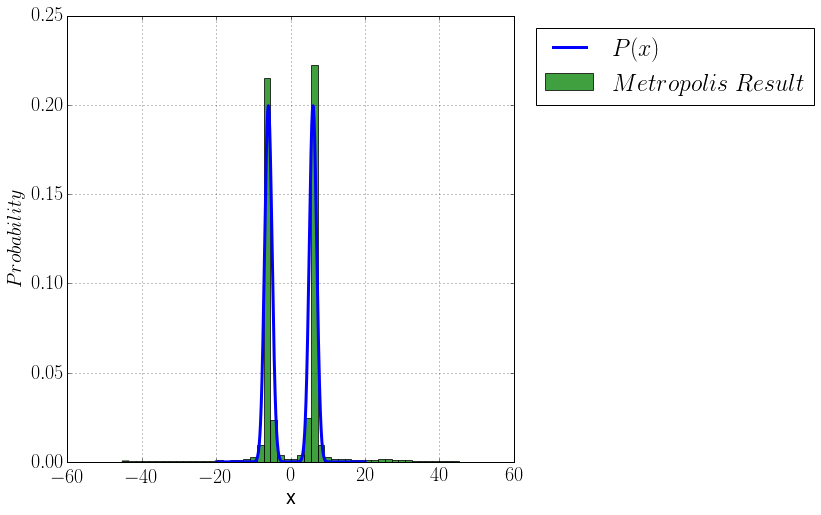

In [136]:
fig, ax = plt.subplots(figsize=(8,8))

# Plot the histogram of my results
ax.hist(res, 50, normed=1, facecolor='green', alpha=0.75, label=r"$Metropolis \ Result$");

# Plot the true distribution
x = np.linspace(-20,20,1000)
ax.plot(x,p(x), color="blue", lw=3, label=r"$P(x)$")

# Format
ax.set_xlabel(r"x")
ax.set_ylabel(r"$Probability$")
ax.grid(True)
ax.legend(bbox_to_anchor=[1.7,1.0])